In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import coint
import statsmodels.api as sm
import scipy.optimize as spop
from sklearn.model_selection import train_test_split

import os

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [95]:
df_closings = pd.DataFrame()
with os.scandir('raw_data/%s' % "Binance_Historical_1h_FUTURES_730_days_2022-06-16T08:05:42") as entries:
    for idx, entry in enumerate(entries):
      instrument = "_".join(entry.name.split("_")[0:2])
      df = pd.read_csv('raw_data/%s/%s' % ("Binance_Historical_1h_FUTURES_730_days_2022-06-16T08:05:42", entry.name), index_col="Date")
      df = df[["Close"]].copy()
      df.columns = [instrument]
      df_closings = pd.concat([df_closings, df], axis=1) 

In [96]:
# low obs count outliers removal
df_observation_num = pd.DataFrame(columns=["observations"])
for column in df_closings.columns:
  df_observation_num.loc[column] = len(df_closings[column].dropna())

drop_columns = []
for idx, row in df_observation_num.iterrows():
  if row.observations < 2070: # arbitrarily selected value based on bottom values from df_observation_num
    drop_columns.append(row.name)
    
# removing outliers from the original DF
df_closings.drop(columns=drop_columns, inplace=True)

# cleaning DF
df_closings.dropna(inplace=True)
df_closings.shape

(2070, 146)

In [4]:
df_top_pairs = pd.read_csv("./processed_data/corr_coint_pairs_temp_2022-06-16T14:53:09.csv")
df_top_pairs.head(15)

,Unnamed: 0,corr,coint
0,SOLBUSD_FUTURES-SOLUSDT_FUTURES,0.999961,5.656579e-07
1,ADABUSD_FUTURES-ADAUSDT_FUTURES,0.999952,1.219130e-07
2,DOGEUSDT_FUTURES-DOGEBUSD_FUTURES,0.999935,3.698161e-08
3,ETHUSDT_FUTURES-ETHBUSD_FUTURES,0.999908,5.806439e-09
4,BNBBUSD_FUTURES-BNBUSDT_FUTURES,0.999903,1.455702e-11
5,XRPBUSD_FUTURES-XRPUSDT_FUTURES,0.999903,2.249442e-14
6,BTCUSDT_FUTURES-BTCBUSD_FUTURES,0.999820,5.043785e-13
7,HBARUSDT_FUTURES-RVNUSDT_FUTURES,0.990681,1.057723e-02
8,RVNUSDT_FUTURES-ZENUSDT_FUTURES,0.989730,1.097054e-02
9,DOTUSDT_FUTURES-MATICUSDT_FUTURES,0.989729,2.741325e-02


In [52]:
# final pair to test strategy
instruments = ['SOLBUSD_FUTURES', 'SOLUSDT_FUTURES']

In [53]:
# check if more data can be loaded
entries = ["SOLBUSD_FUTURES_1h.csv", "SOLUSDT_FUTURES_1h.csv"]

df_closings = pd.DataFrame()

for idx, entry in enumerate(entries):
        # if entry.name.split("_")[0] in intersection:
      instrument = "_".join(entry.split("_")[0:2])
      df = pd.read_csv('raw_data/%s/%s' % ("Binance_Historical_1h_FUTURES_730_days_2022-06-16T08:05:42", entry), index_col="Date", parse_dates=["Date"])
      df = df[["Close"]].copy()
      df.columns = [instrument]
      df_closings = pd.concat([df_closings, df], axis=1) 

# cleaning DF
df_closings.dropna(inplace=True)
df_closings.shape

(6869, 2)

In [54]:
train_set = np.arange(0, int(df_closings.shape[0]*0.8))
test_set = np.arange(train_set.shape[0], df_closings.shape[0])
print(len(train_set), len(test_set), len(train_set) + len(test_set))

5495 1374 6869


In [55]:
# determining the hedge ratio
model = sm.OLS(df_closings.iloc[train_set][[instruments[0]]], df_closings.iloc[train_set][[instruments[1]]])
results = model.fit()
hedge_ratio = results.params[0]
hedge_ratio

1.0003137975350822

In [56]:
spread = df_closings[instruments[0]] - hedge_ratio*df_closings[instruments[1]]

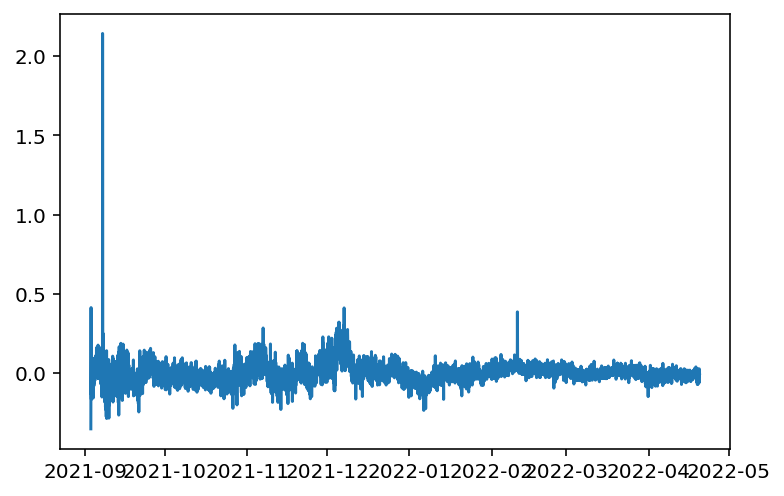

In [57]:
plt.plot(spread.iloc[train_set])

In [58]:
spread_mean=np.mean(spread.iloc[train_set])
spread_mean

-0.0004154360622437993

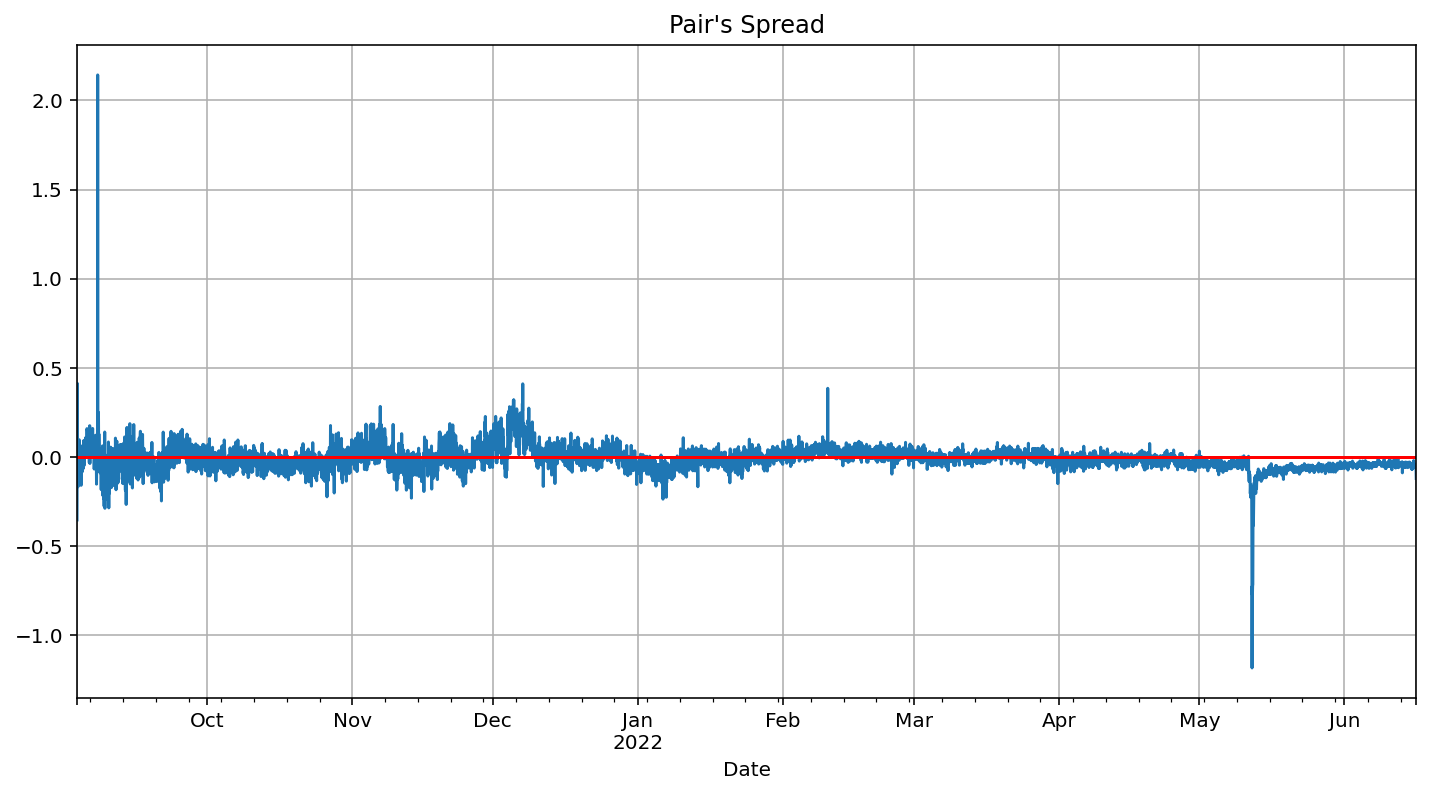

In [59]:
spread.plot(figsize=(12, 6), title = "Pair's Spread")
plt.grid(True)
plt.axhline(spread_mean, color='red')
plt.show()

In [60]:
spread_std=np.std(spread.iloc[train_set])
spread_std

0.0676680530722716

In [61]:
tp_year = (df_closings.shape[0] / ((df_closings.index[-1] - df_closings.index[0]).days / 365.25))

In [69]:
df_closings['zscore']=(spread-spread_mean)/spread_std

df_closings['positions_%s_Long' % instruments[0]]=0
df_closings['positions_%s_Long' % instruments[1]]=0
df_closings['positions_%s_Short' % instruments[0]]=0
df_closings['positions_%s_Short' % instruments[1]]=0

df_closings.loc[df_closings.zscore>=1.5, ('positions_%s_Short' % instruments[0], 'positions_%s_Short' % instruments[1])]=[-1, 1] # Short spread 
df_closings.loc[df_closings.zscore<=-1.5, ('positions_%s_Long' % instruments[0], 'positions_%s_Long' % instruments[1])]=[1, -1] # Buy spread
df_closings.loc[df_closings.zscore<=0.5, ('positions_%s_Short' % instruments[0], 'positions_%s_Short' % instruments[1])]=0 # Exit short spread
df_closings.loc[df_closings.zscore>=-0.5, ('positions_%s_Long' % instruments[0], 'positions_%s_Long' % instruments[1])]=0 # Exit long spread

df_closings.fillna(method='ffill', inplace=True) # ensure existing positions are carried forward unless there is an exit signal

positions_long=df_closings.loc[:, ('positions_%s_Long' % instruments[0], 'positions_%s_Long' % instruments[1])]
positions_short=df_closings.loc[:, ('positions_%s_Short' % instruments[0], 'positions_%s_Short' % instruments[1])]
positions=np.array(positions_long)+np.array(positions_short)
positions=pd.DataFrame(positions)

dailyret=df_closings.loc[:, (instruments[0], instruments[1])].pct_change()
# log ret ver
# dailyret = np.log(df_closings.loc[:, (instruments[0], instruments[1])] / df_closings.loc[:, (instruments[0], instruments[1])].shift())

pnl=(np.array(positions.shift())*np.array(dailyret)).sum(axis=1)

sharpe_trainset=np.sqrt(tp_year)*np.mean(pnl[train_set[1:]])/np.std(pnl[train_set[1:]])
sharpe_testset=np.sqrt(tp_year)*np.mean(pnl[test_set])/np.std(pnl[test_set])




In [70]:
print(sharpe_trainset, sharpe_testset)

12.623773208184884 1.0244012250912455


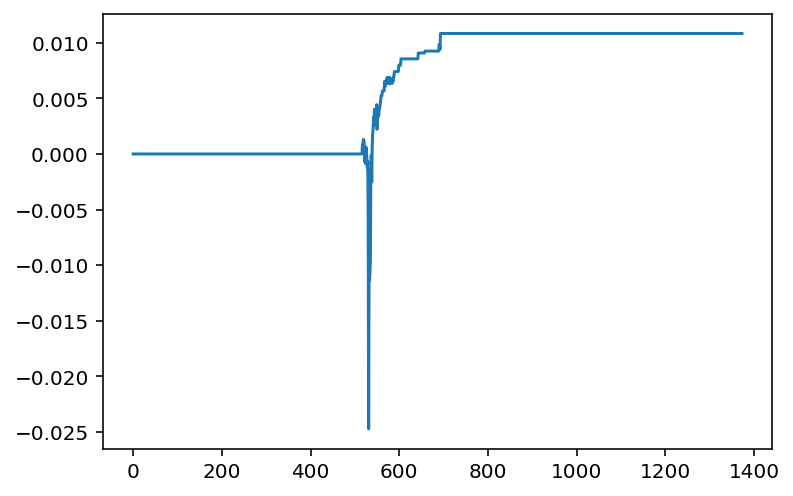

In [71]:
plt.plot(np.cumsum(pnl[test_set]))

In [65]:
# implement stop-lossess & trading costs

In [66]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

In [67]:
result_adf = adfuller(spread)
result_adf

(-5.805750754979473,
 4.5208508381419483e-07,
 35,
 6833,
 {'1%': -3.4313073771855596,
  '5%': -2.8619630821743827,
  '10%': -2.566995202852806},
 -21222.943488550387)

In [68]:
result_kpss = kpss(spread)
result_kpss

/Users/mscbr/opt/anaconda3/envs/trader_env/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(1.7866292310683334,
 0.01,
 49,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

<h2 style="color: orange">Spencer PAO</h2>

In [18]:
from matplotlib.pyplot import figure

In [19]:
# calculate z-score
def zscore(series):
  return (series - series.mean()) / np.std(series)

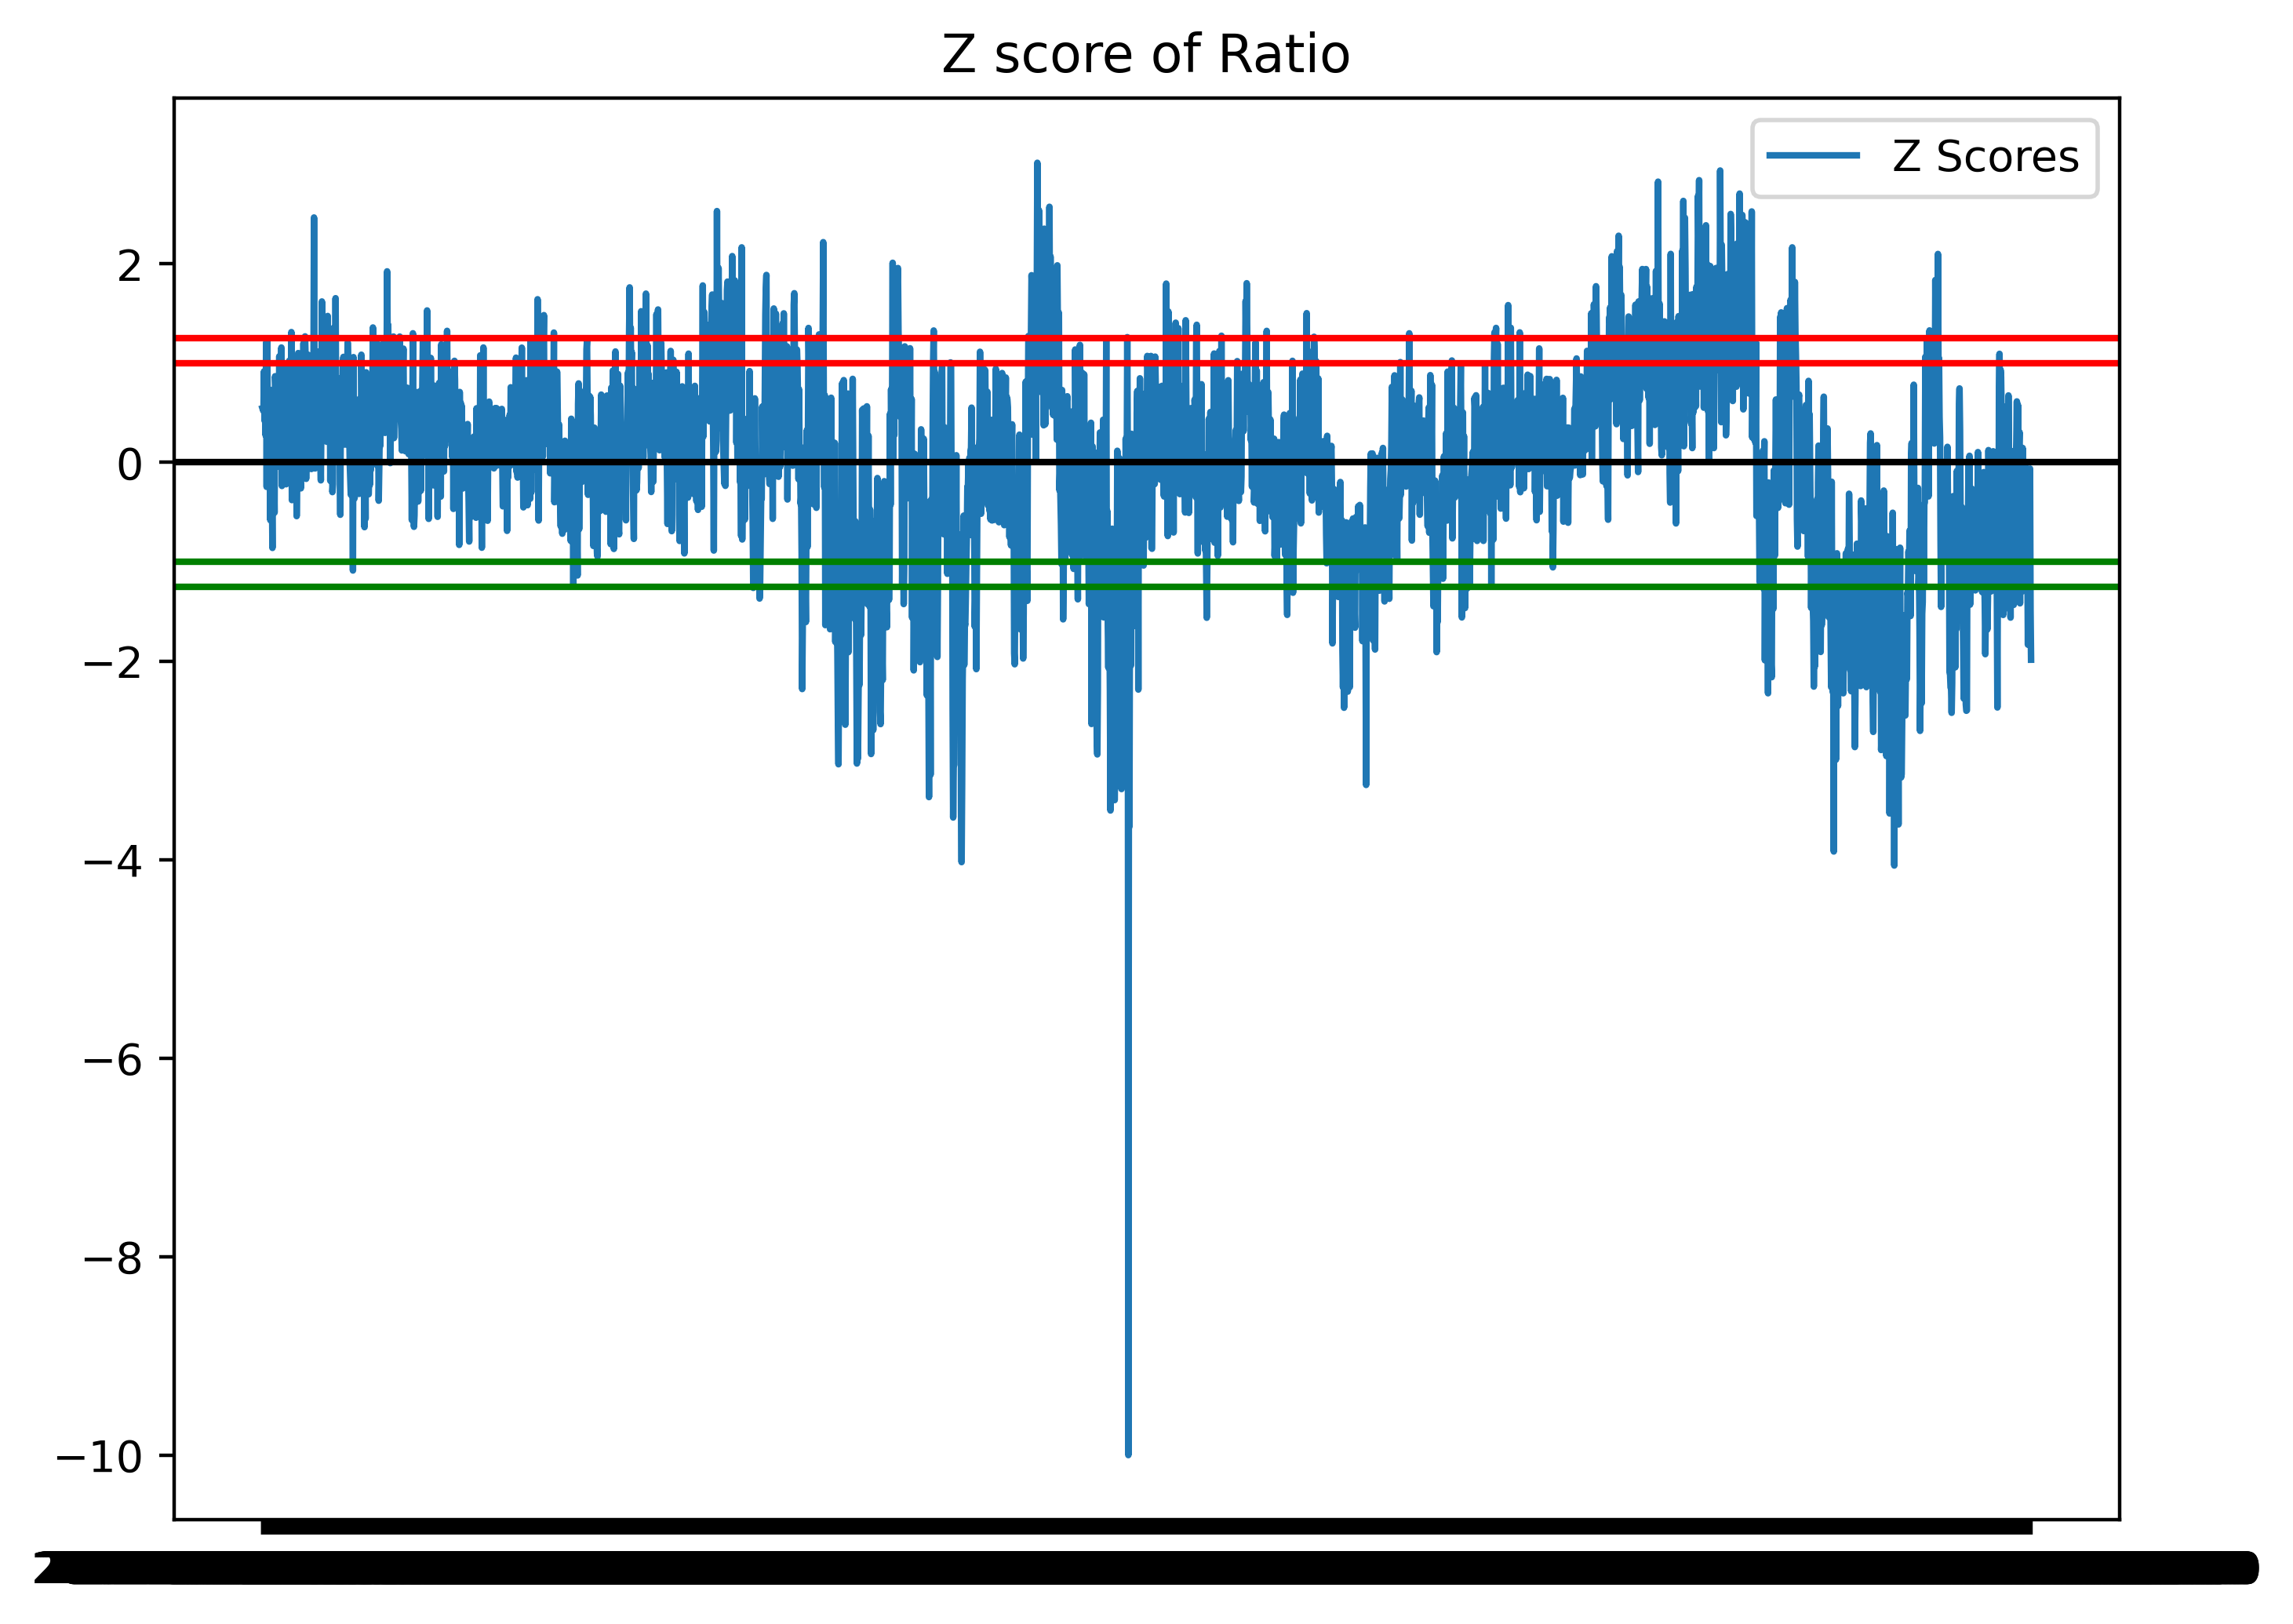

In [21]:
# NOTE, here you can either use the spread OR the Price ratio approach. Anyways, let's standardize the ratio so we can have a 
# upper and lower bound to help evaluate our trends.. Let's stick with the ratio data.
figure(figsize=(8, 6), dpi=200)
# Calculate the Zscores of each row.
df_zscore = (spread - spread.mean())/spread.std()
plt.plot(df_zscore, label = "Z Scores")
plt.axhline(df_zscore.mean(), color = 'black')
plt.axhline(1.0, color='red') # Setting the upper and lower bounds to be the z score of 1 and -1 (1/-1 standard deviation)
plt.axhline(1.25, color='red') # 95% of our data will lie between these bounds.
plt.axhline(-1.0, color='green') # 68% of our data will lie between these bounds.
plt.axhline(-1.25, color='green') # 95% of our data will lie between these bounds.
plt.legend(loc = 'best')
plt.title('Z score of Ratio')
plt.show()
# For the most part, the range that exists outside of these 'bands' must come converge back to the mean. Thus, you can 
# determine when you can go long or short the pair (BRK_B to MSFT).

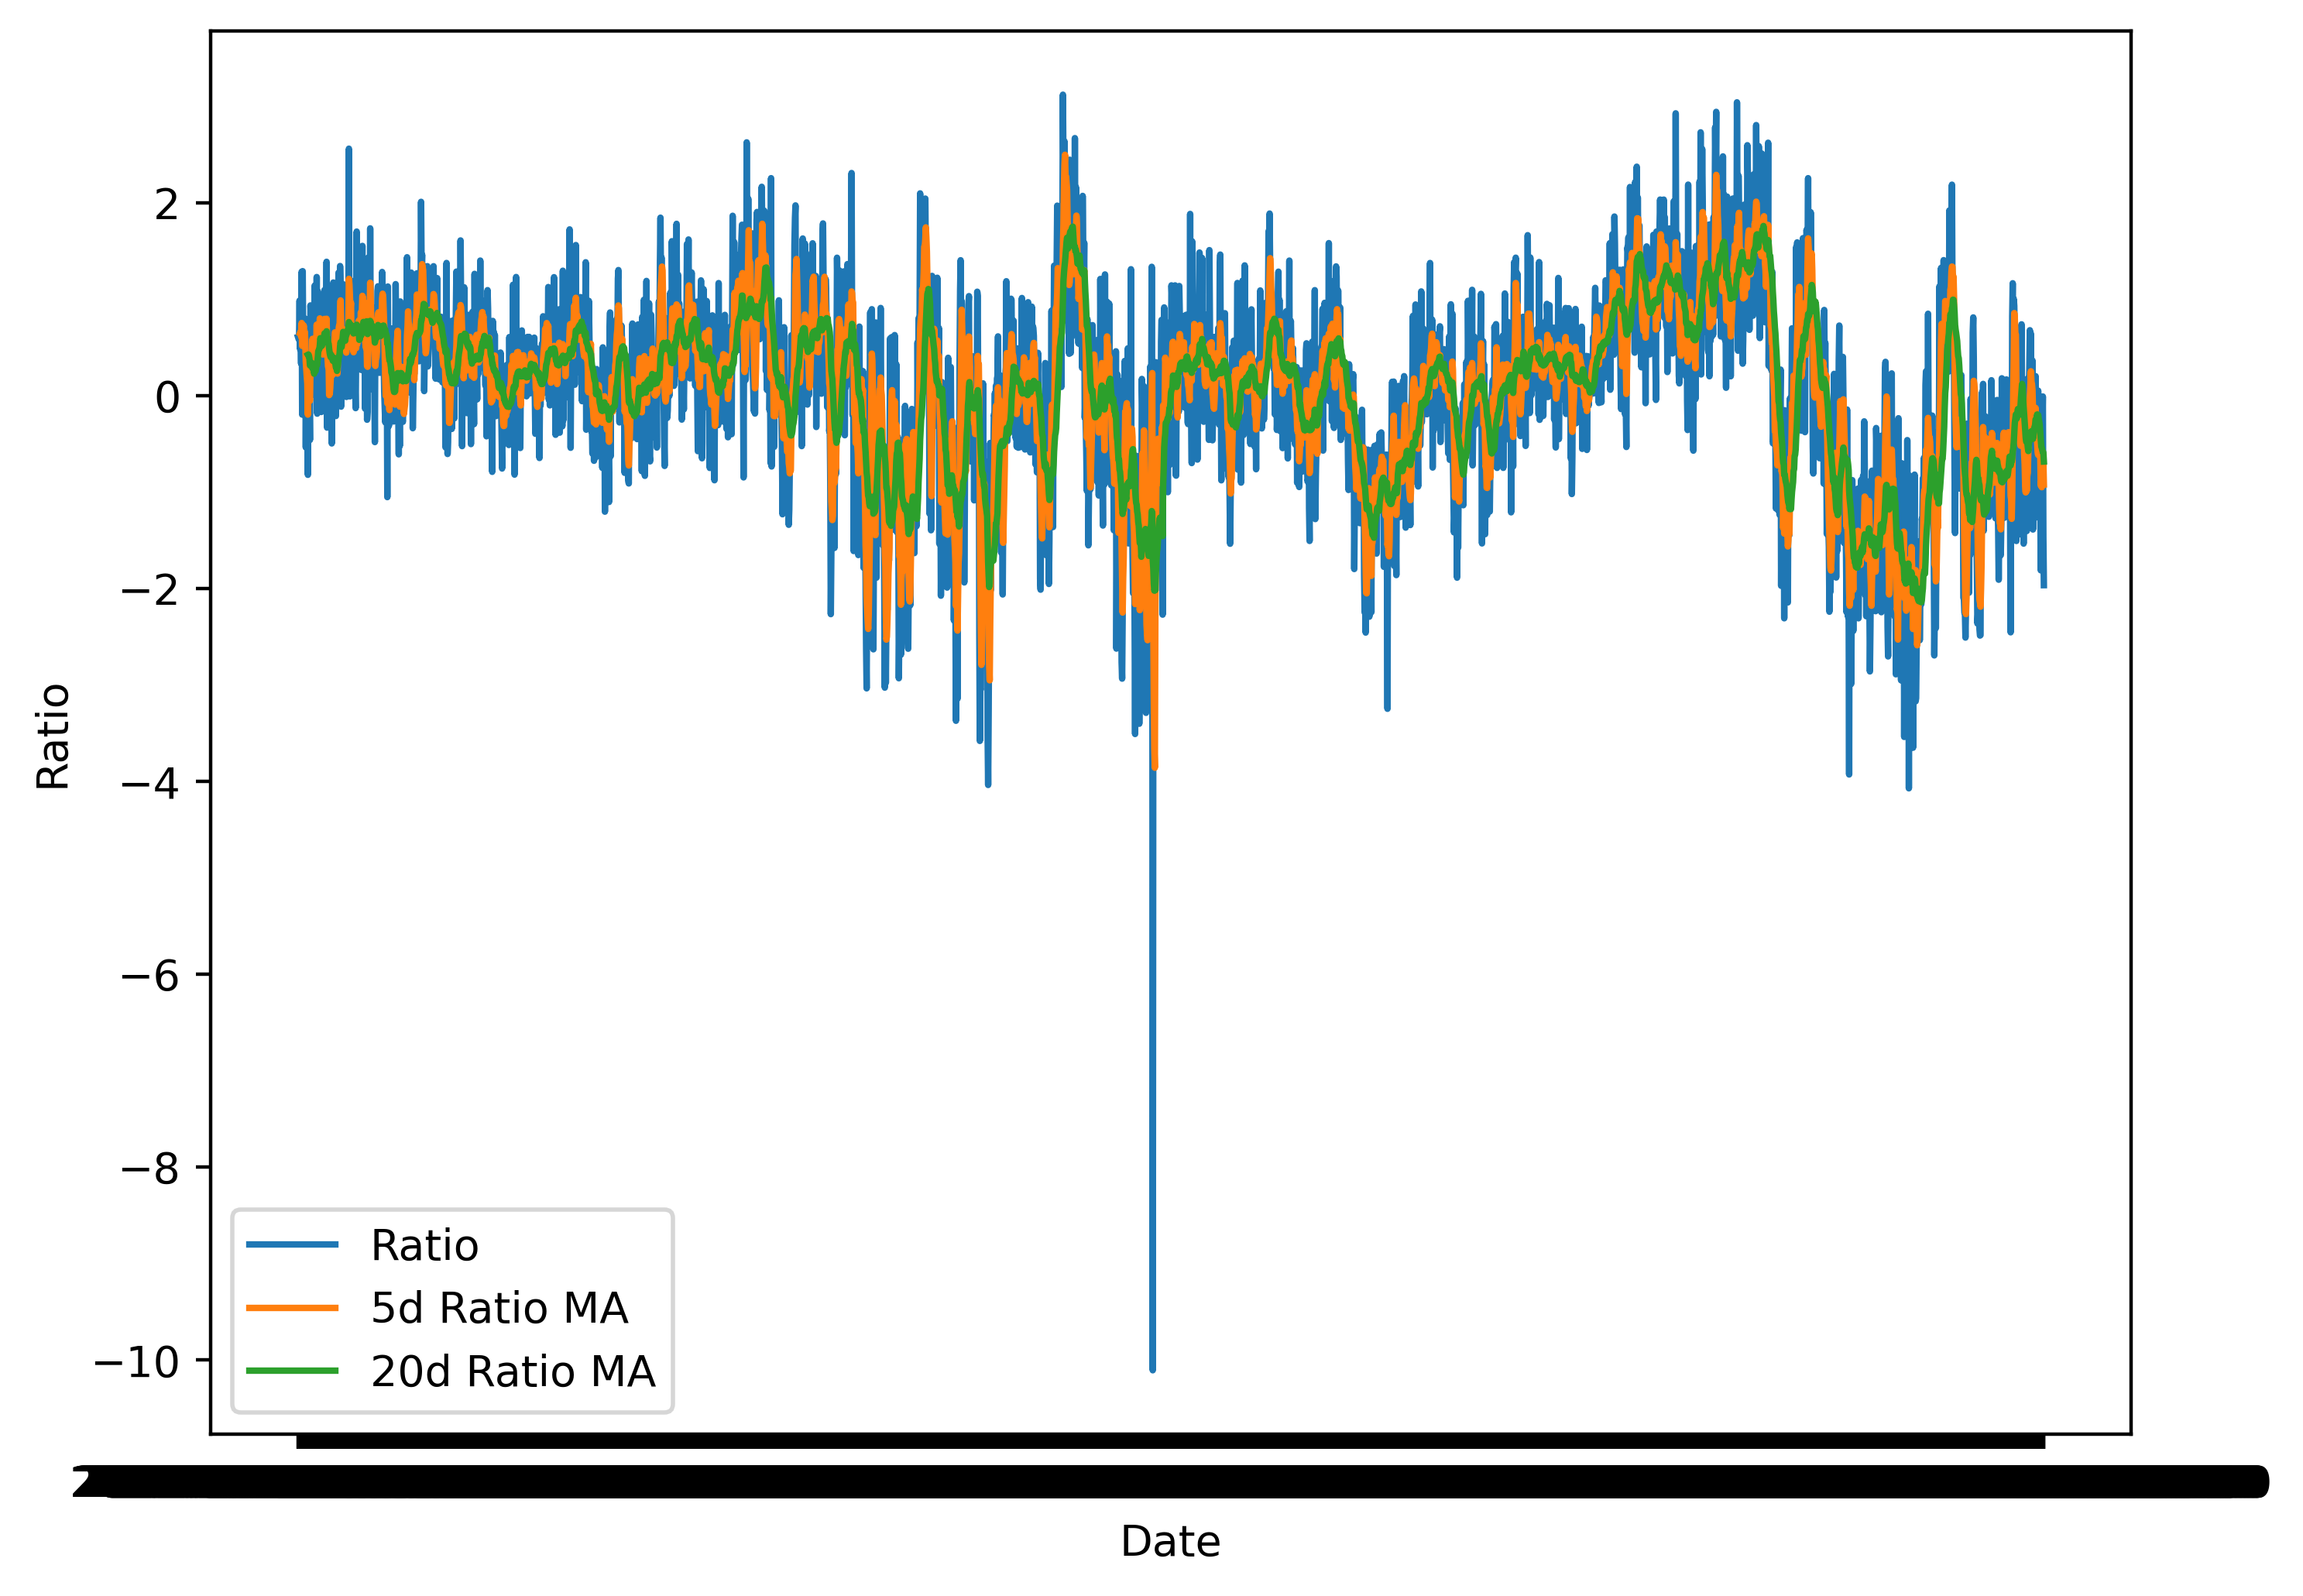

In [22]:
figure(figsize=(8, 6), dpi=200)
ratios_mavg5 = spread.rolling(window=5, center=False).mean()
ratios_mavg20 = spread.rolling(window=20, center=False).mean()
std_20 = spread.rolling(window=20, center=False).std()
zscore_20_5 = (ratios_mavg5 - ratios_mavg20)/std_20
plt.plot(spread.index, spread.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg20.index, ratios_mavg20.values)
plt.legend(['Ratio', '5d Ratio MA', '20d Ratio MA'])
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.show()

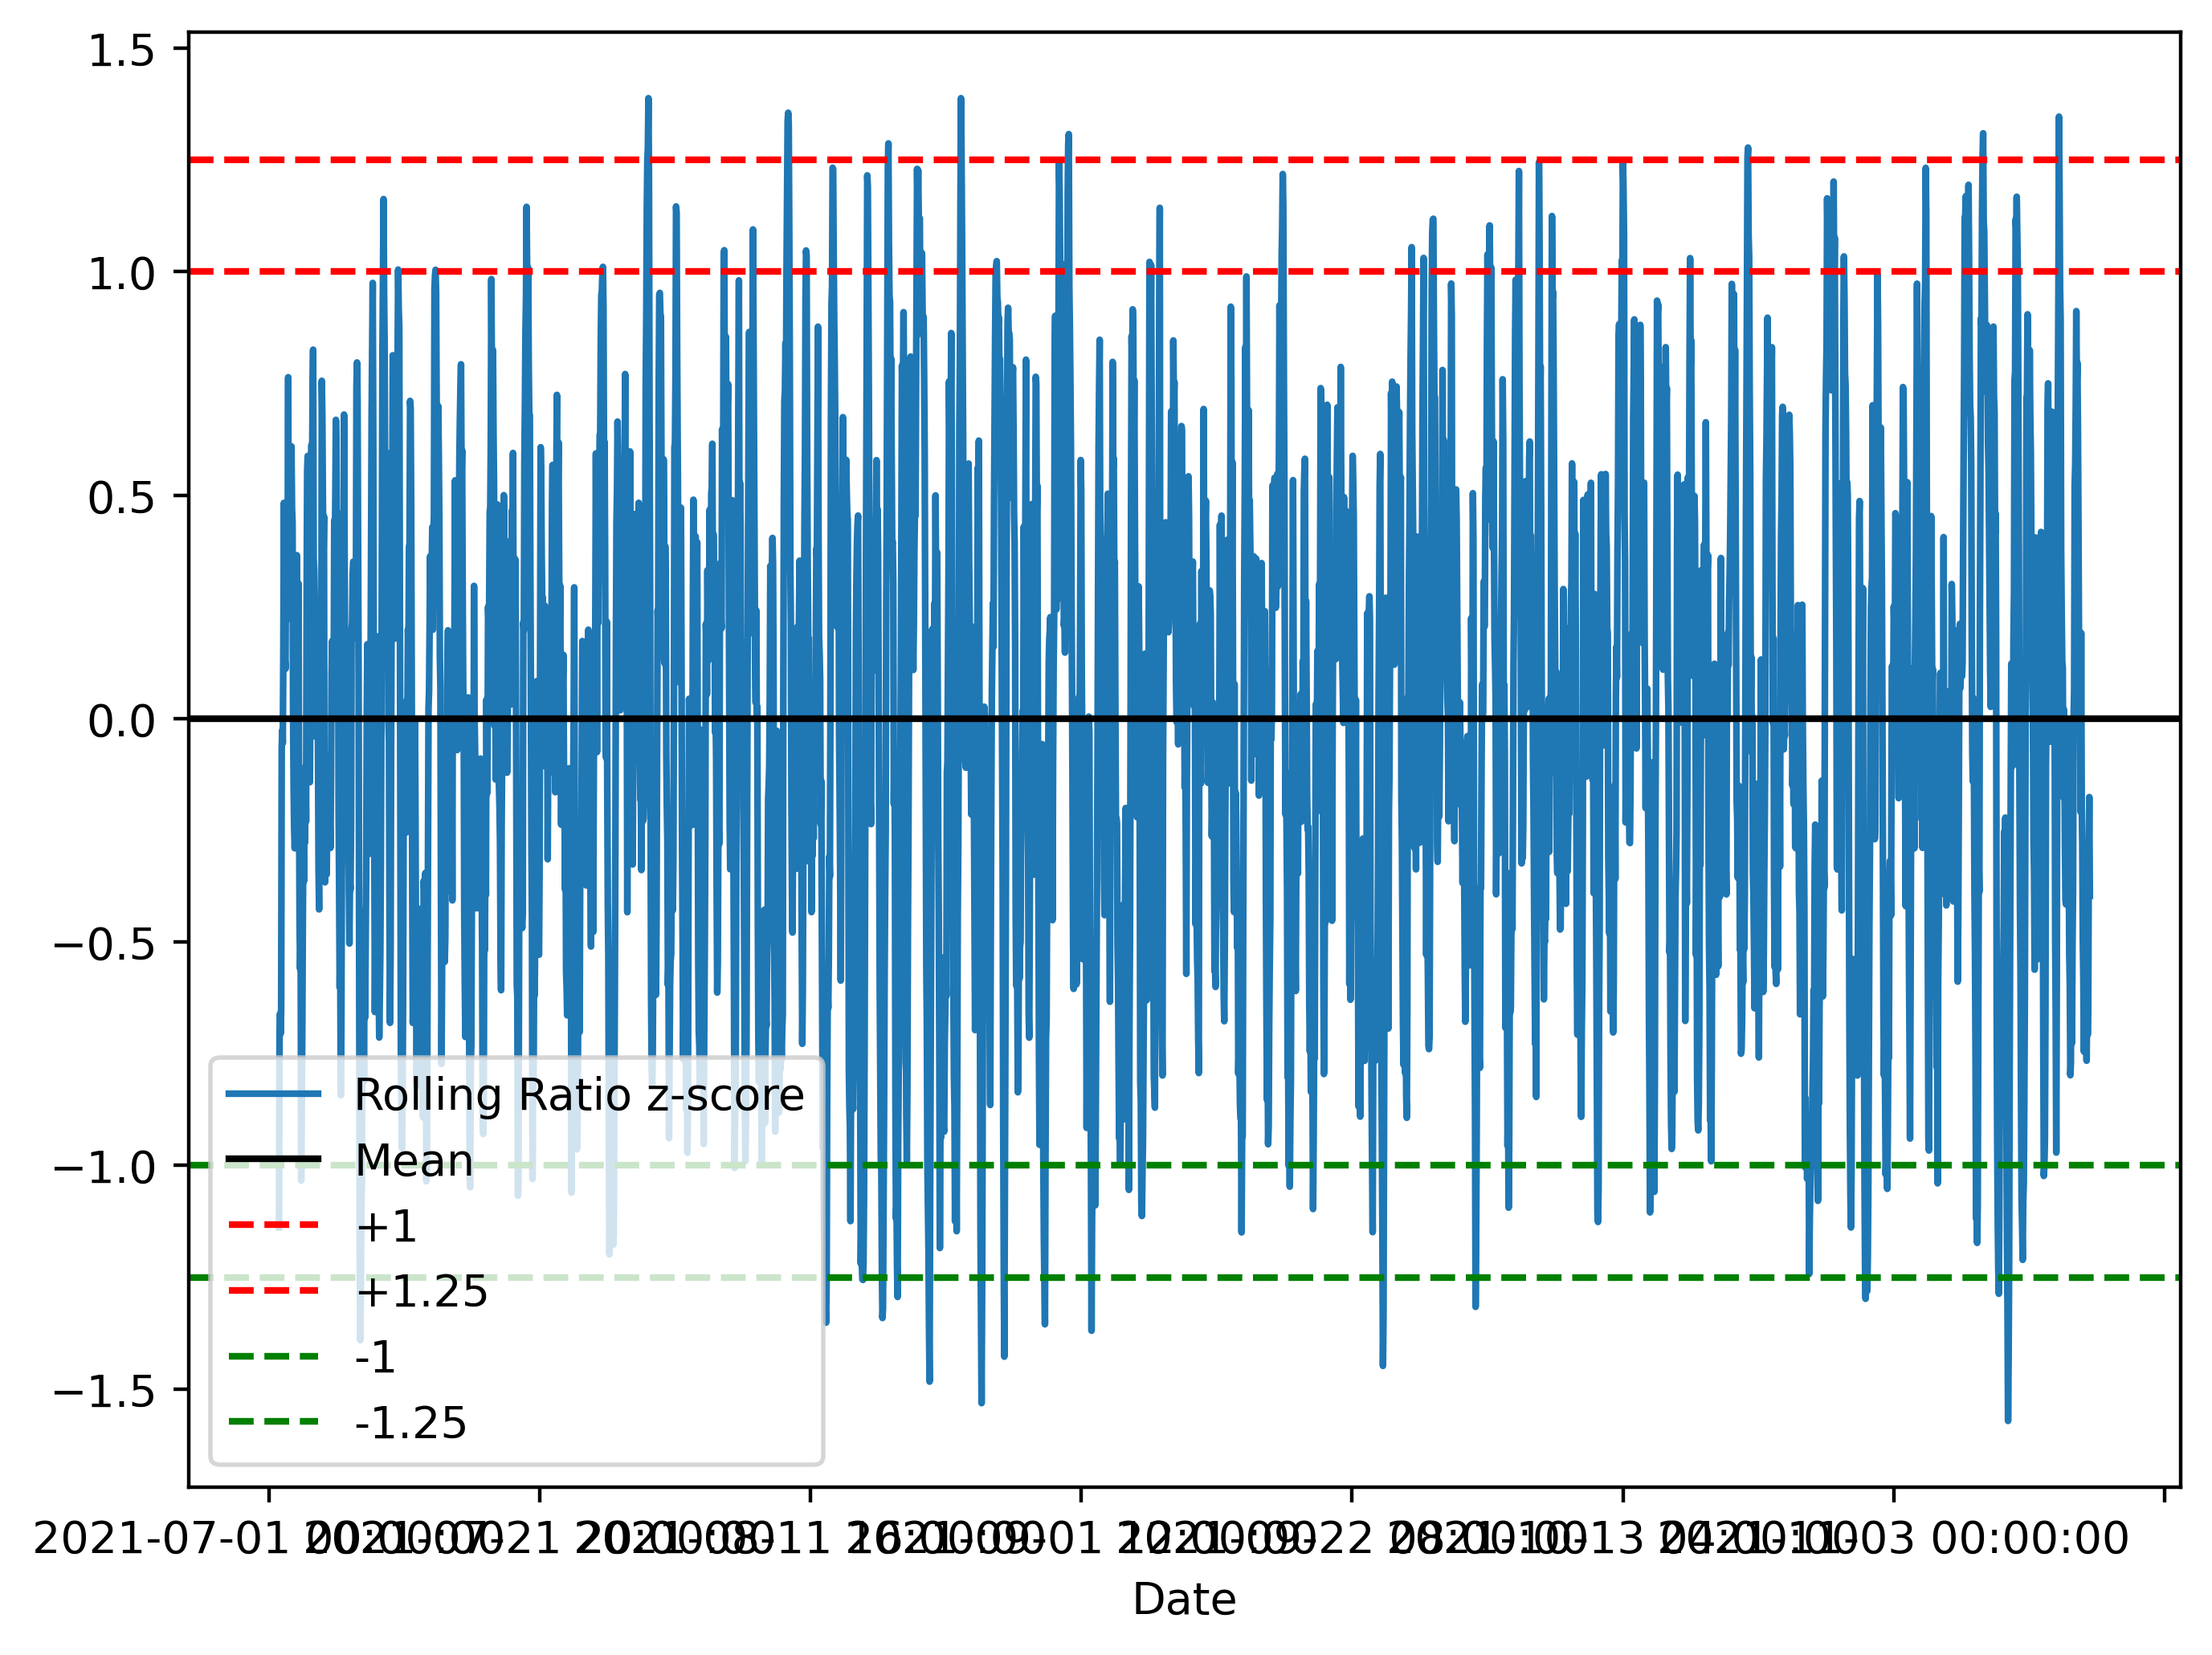

In [23]:
figure(figsize=(8, 6), dpi=200)
zscore_20_5.plot()
plt.axhline(0, color='black')
plt.axhline(1, color='red', linestyle='--')
plt.axhline(1.25, color='red', linestyle='--')
plt.axhline(-1, color='green', linestyle='--')
plt.axhline(-1.25, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-score', 'Mean', '+1','+1.25','-1','-1.25'])
plt.show()

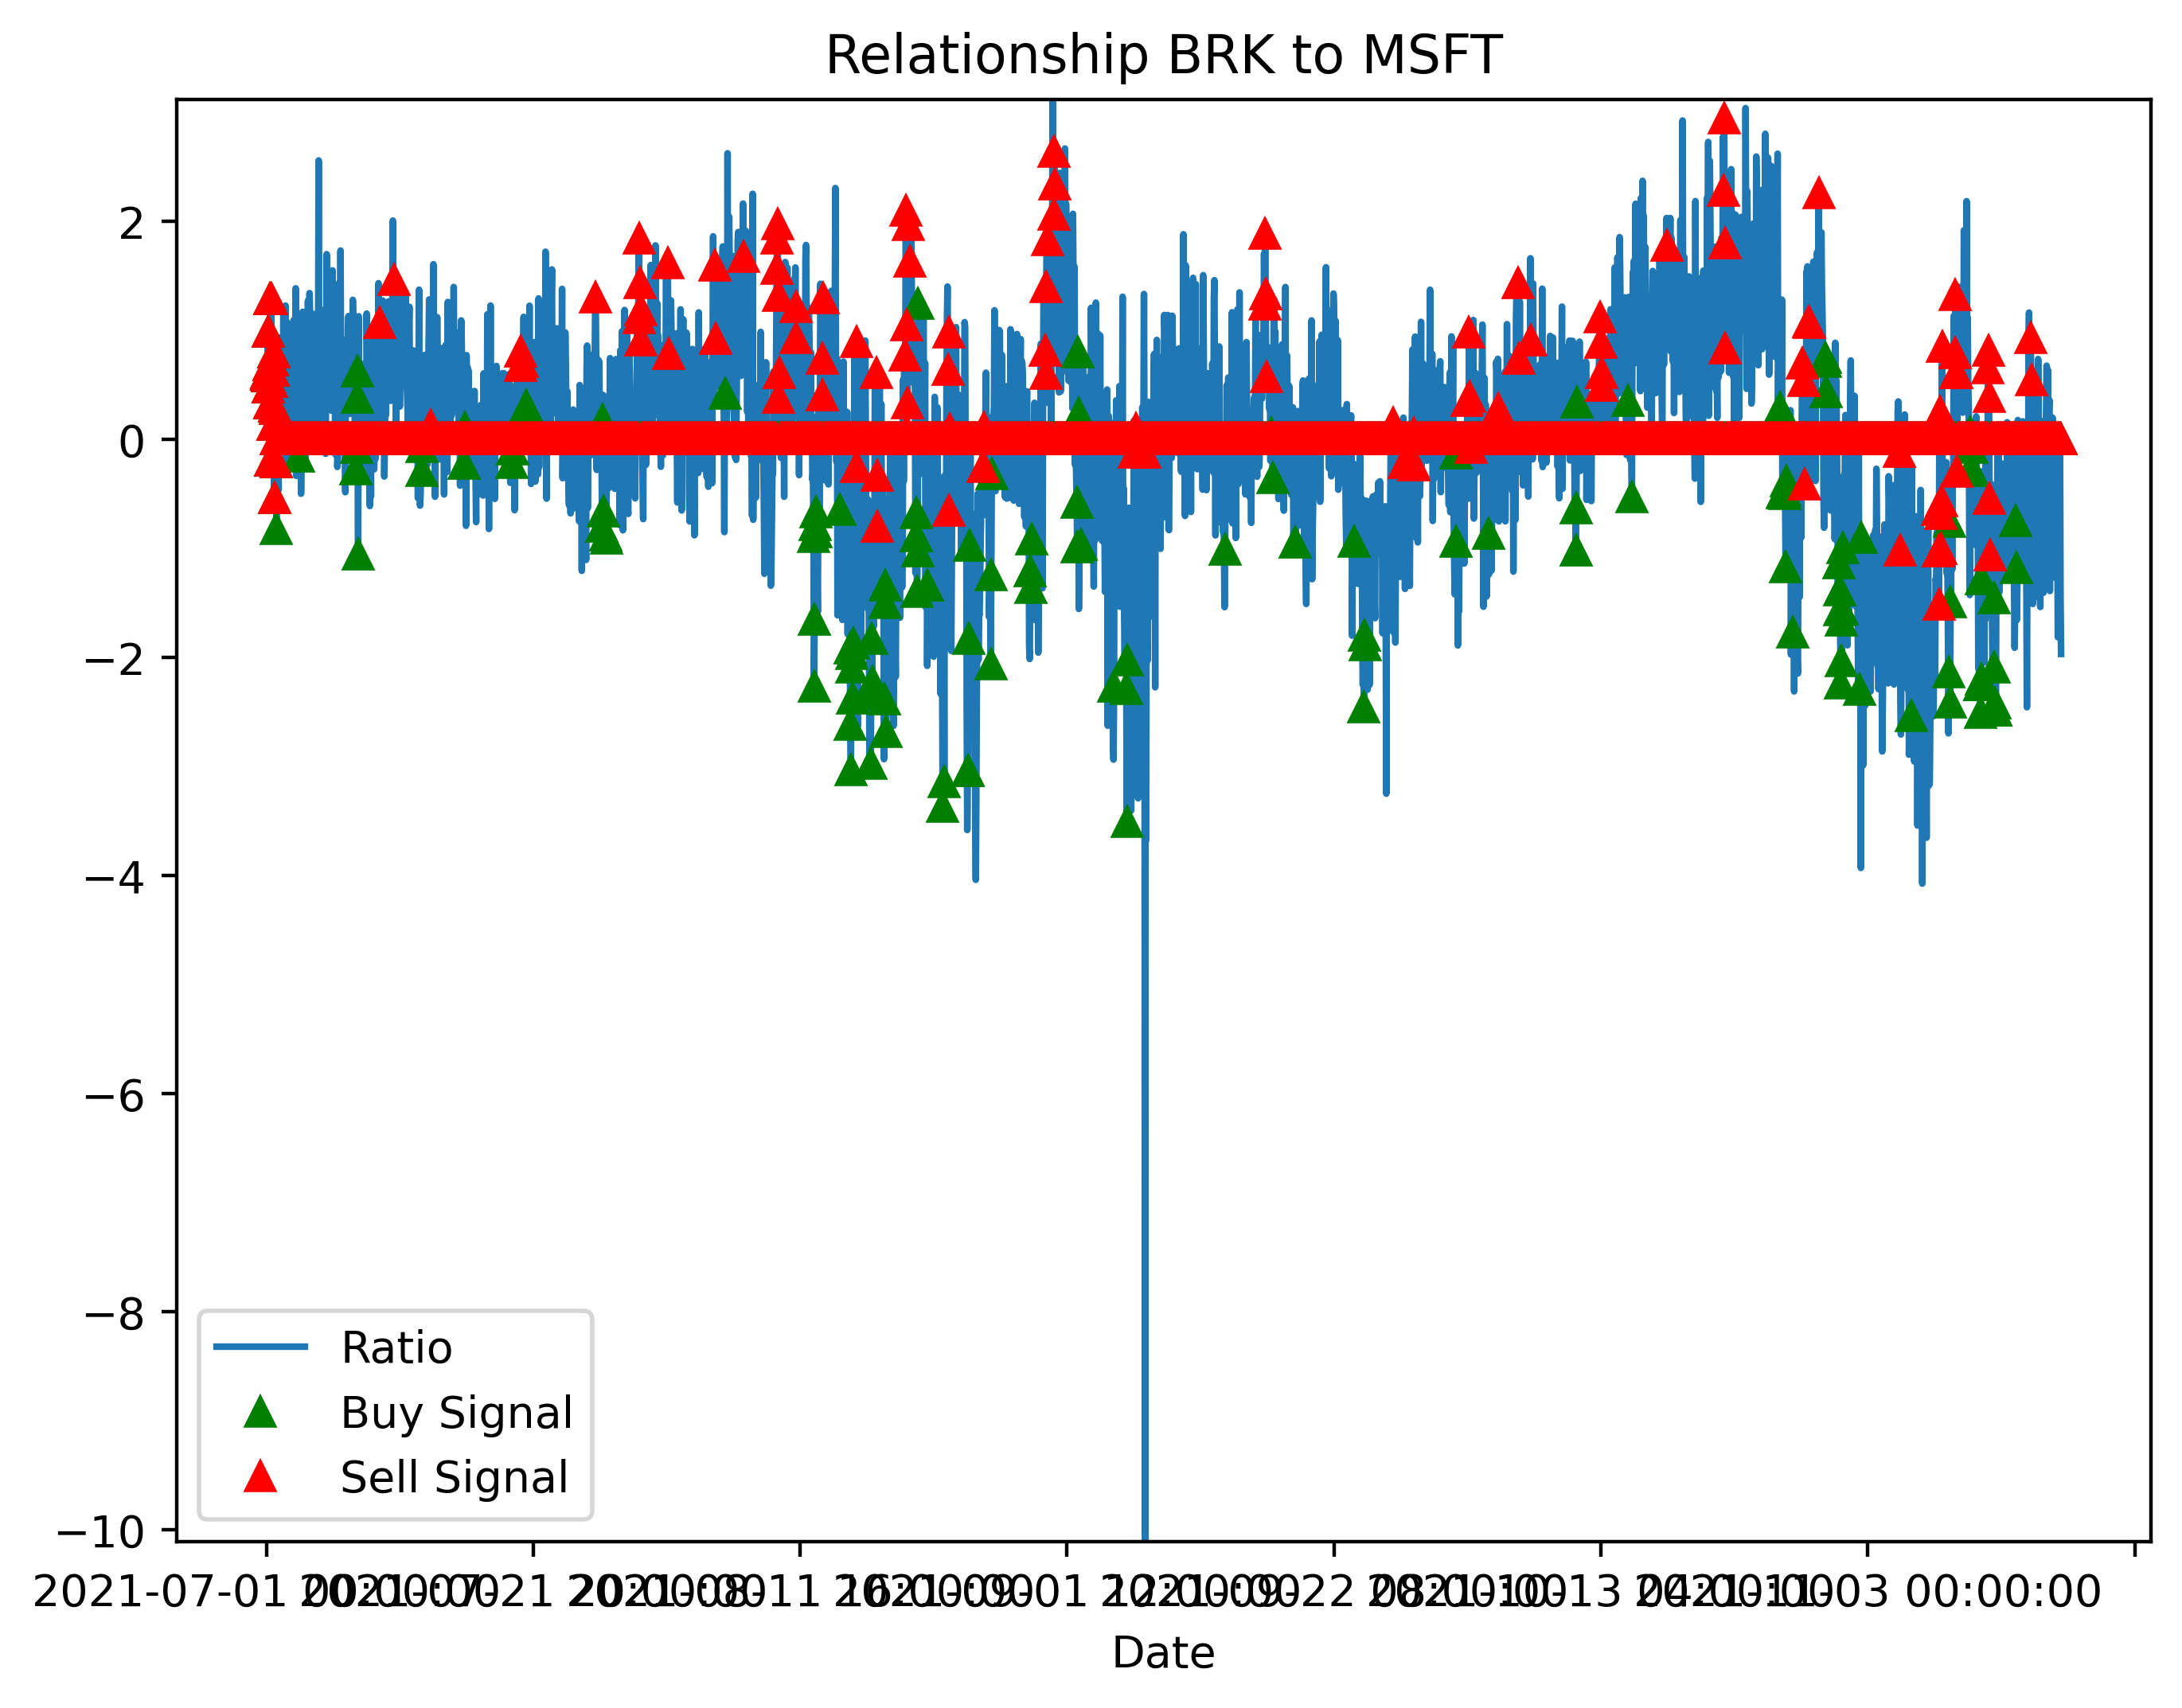

In [24]:
figure(figsize=(8, 6), dpi=200)
spread.plot()
buy = spread.copy()
sell = spread.copy()
buy[zscore_20_5>-1] = 0
sell[zscore_20_5<1] = 0
buy.plot(color='g', linestyle='None', marker='^')
sell.plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, spread.min(), spread.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.title('Relationship BRK to MSFT')
plt.show()